In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy

from IPython.core.debugger import set_trace

import import_ipynb
from config import *

%load_ext autoreload
%autoreload 2

importing Jupyter notebook from config.ipynb


In [2]:
class Environment(object):
    """
        Implementation of the Jop Shop Problem
    """

    def __init__(self, config):
        
        self.config = config

        #Initialize environment variables
        self.clear()
        
    def _place(self, job, task, machine):       
        
        # Task startTime
        if task == 0:
            self.taskTimes[job][task][0] = self.machineReadyTime[machine]
        
        else:
            self.taskTimes[job][task][0] = max(self.machineReadyTime[machine], self.taskTimes[job][task-1][1])
            
        # Task endTime
        self.taskTimes[job][task][1] = self.taskTimes[job][task][0] + self.duration[job][task]
        
        # Update machine next ready time
        self.machineReadyTime[machine] = self.taskTimes[job][task][1]
        
        
    def step(self, machines, duration, placements):

        assert len(machines) == len(duration) == self.config.num_jobs
        assert len(placements) == self.config.num_machines
        
        self.machines = machines
        self.duration = duration
        self.placements = placements
        
            
        # Internal variables
        self.taskTimes = [[[0, 0] for _ in range(self.config.num_tasksperjob)] for _ in range(self.config.num_jobs)]  #[start, end]
        self.machineReadyTime = [0 for _ in range(self.config.num_machines)]
        
        self.placementsTime = copy.deepcopy(self.placements)
        self.placementsTimePlot = copy.deepcopy(self.placements)
        self.placementsColorPlot = copy.deepcopy(self.placements)
        
        
        # Tasks still to be placed
        todo = copy.deepcopy(placements)
        
        # Mask indicating tasks that can be placed (previous task in job already placed)
        mask = np.zeros([self.config.num_jobs, self.config.num_tasksperjob], dtype=bool)
        mask[:,0] = True
        

        # While...
        placing = True
        while(placing):
            
            for m, job_task in enumerate(todo):          
                try:
                    job = job_task[0][0]
                    task = job_task[0][1]
                
                    if mask[job, task]:
                        
                        # Place task in machine
                        self._place(job, task, m)
                                                
                        # Update mask
                        if task < self.config.num_tasksperjob-1:
                            mask[job, task+1] = True
                            
                        # Remove task
                        job_task.pop(0)
                        
                except:
                    pass

            if all(v == [] for v in todo):
                placing = False

        # Output
        self.makespan = max(self.machineReadyTime)
        
        
    def _compute_info(self):
        
        # Colormap
        cmap = plt.cm.get_cmap('tab10')
        colormap = [cmap(np.float32(i+1)/(self.config.num_jobs+1)) for i in range(self.config.num_jobs)]
        
        for machine, tasks in enumerate(self.placements):
            for i, jobtask in enumerate(tasks):

                job = jobtask[0]
                task = jobtask[1]
                
                # Time (start, end)
                self.placementsTime[machine][i] = self.taskTimes[job][task]
                
                # Time_plot (start, duration)
                self.placementsTimePlot[machine][i][:] = self.taskTimes[job][task]
                self.placementsTimePlot[machine][i][1] = self.placementsTimePlot[machine][i][1] - self.placementsTimePlot[machine][i][0]
                
                # Color_plot
                self.placementsColorPlot[machine][i] = colormap[jobtask[0]]
                
                
    def plot(self, save=False, name="figure.pdf"):
        
        # Compute additional variables
        self._compute_info()
        
        # Matplotlib
        mpl.style.use('seaborn')
        fig, ax = plt.subplots(figsize=(8, 6), dpi= 80, facecolor="white", edgecolor="white")
        ax.set_facecolor("#E4ECF5")

        for i in range(self.config.num_machines):
            ax.broken_barh(self.placementsTimePlot[i], (10*(self.config.num_machines-i), 4), facecolors=self.placementsColorPlot[i], edgecolor="#E4ECF5")

        ax.set_ylim(8, 10*(self.config.num_machines+1))
        ax.set_xlim(-2, 10+max(self.machineReadyTime))
        ax.set_xlabel('time')

        ax.set_yticks(list(range(15, 15+self.config.num_machines*10, 10)))
        ax.set_yticklabels(['Machine'+ str(i) for i in reversed(range(self.config.num_machines))])
        
        ax.grid(True)
        #ax.xaxis.grid(True, which="minor", color="white", linewidth=20)
        ax.xaxis.grid(True)
        ax.yaxis.grid(False)
        ax.set_axisbelow(True)
        fig.tight_layout()
        plt.show()
        
        if save:
            fig.savefig(name)
        
    def clear(self):

        # Clear placement
        self.machines = None
        self.duration = None
        self.placements = None
        
        # Internal variables
        self.taskTimes = None
        self.machineReadyTime = None
        
        self.placementsTime = None
        self.placementsTimePlot = None
        self.placementsColorPlot = None
        
        # Output
        self.makespan = None
        self.constraint_idleTime = 0



Makespan:  139


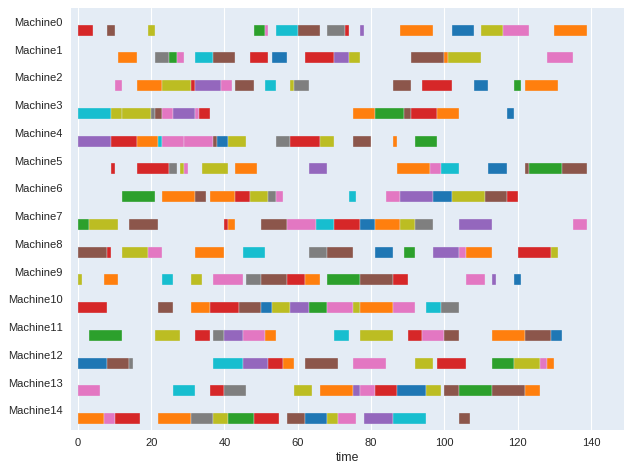

In [5]:

if __name__ == "__main__":
    
    
    # Import environment
    config = Config()
    config.machine_profile = "medium_default"
    config.job_profile = "medium_default"
    config.reconfigure()
    
    # Configure environment
    env = Environment(config)
    env.clear()
    
    
    # Read problem instance
    filename = "datasets/inference/dataset_medium.data"

    with open(filename, "r") as file:
        NB_JOBS, NB_MACHINES = [int(v) for v in file.readline().split()]
        JOBS = [[int(v) for v in file.readline().split()] for i in range(NB_JOBS)]

    #-----------------------------------------------------------------------------
    # Prepare the data for modeling
    #-----------------------------------------------------------------------------

    # Build list of machines. MACHINES[j][s] = id of the machine for the operation s of the job j
    MACHINES = [[JOBS[j][2 * s] for s in range(NB_MACHINES)] for j in range(NB_JOBS)]

    # Build list of durations. DURATION[j][s] = duration of the operation s of the job j
    DURATION = [[JOBS[j][2 * s + 1] for s in range(NB_MACHINES)] for j in range(NB_JOBS)]

    
    # Create a basic heuristic
    #placements = [[] for m in range(NB_MACHINES)]
    
    #for t in range(0, NB_MACHINES):
    #    for j in range(NB_JOBS):
    #        placements[MACHINES[j][t]].append([j,t])
           

    # Allocate service in the environment
    env.step(MACHINES, DURATION, placements_medium_nn)
    
    print("Makespan: ", env.makespan)
    
    
    env.plot(save=False, name="images/medium_nn.pdf")
    